In [ ]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
my_transforms = transforms.Compose(
    [  
        transforms.Resize((36, 36)), 
        transforms.RandomCrop((32, 32)), 
        transforms.ColorJitter(brightness=0.5), 
        transforms.RandomRotation(degrees=45), 
        transforms.RandomHorizontalFlip(p=0.5), 
        transforms.RandomVerticalFlip(p=0.05),  
        transforms.RandomGrayscale(p=0.2),
        transforms.ToTensor(),
    ]
)

train_dataset = torchvision.datasets.CIFAR100(
    root = '.',
    train=True,
    download=True,
    transform = my_transforms
)

test_dataset = torchvision.datasets.CIFAR100(
    root = '.',
    train=True,
    download=True,
    transform = transforms.ToTensor()
)

batch_size = 128
train_loader = torch.utils.data.DataLoader(
    dataset = train_dataset,
    batch_size = batch_size,
    shuffle=True
)

test_loader = torch.utils.data.DataLoader(
    dataset = test_dataset,
    batch_size = batch_size,
    shuffle=False
)

  0%|          | 0/169001437 [00:00<?, ?it/s]

Extracting ./cifar-100-python.tar.gz to .
Files already downloaded and verified


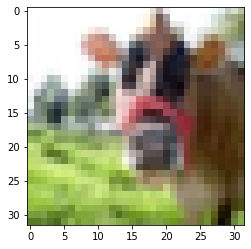

In [ ]:
plt.imshow(train_dataset.data[0])

In [ ]:
k = len(set(train_dataset.targets))
k

100

In [ ]:
train_dataset.data.shape

(50000, 32, 32, 3)

In [ ]:
model = nn.Sequential(
    nn.Conv2d(3, 6, 5),
    nn.ReLU(),
    nn.BatchNorm2d(6),
    nn.MaxPool2d(2,2),
    

    nn.Conv2d(6, 16, 5),
    nn.ReLU(),
    nn.BatchNorm2d(16),
    nn.MaxPool2d(2,2),

    nn.Flatten(),

    nn.Linear(16*5*5, 300),
    nn.ReLU(),
    nn.Linear(300, 200),
    nn.ReLU(),
    nn.Linear(200, 100)
)

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

Sequential(
  (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (1): ReLU()
  (2): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (4): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (5): ReLU()
  (6): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (8): Flatten(start_dim=1, end_dim=-1)
  (9): Linear(in_features=400, out_features=300, bias=True)
  (10): ReLU()
  (11): Linear(in_features=300, out_features=200, bias=True)
  (12): ReLU()
  (13): Linear(in_features=200, out_features=100, bias=True)
)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

In [45]:
epochs=50
def traning(epochs, train_loader, test_loader, criterion, optimizer):
  train_losses = np.zeros(epochs)
  test_losses = np.zeros(epochs)
  for i in range(epochs):
    train_loss = []
    for input, target in train_loader:
      input, target = input.to(device), target.to(device)
      optimizer.zero_grad()
      output = model(input)
      loss = criterion(output, target)
      train_loss.append(loss.item())
      loss.backward()
      optimizer.step()
    train_loss = np.mean(train_loss)
    
    test_loss = []
    for input, target in test_loader:
      input, target = input.to(device), target.to(device)
      output = model(input)
      loss = criterion(output, target)
      test_loss.append(loss.item())
    test_loss = np.mean(test_loss)

    train_losses[i] = train_loss
    test_losses[i] = test_loss
    print(f'Epoch: {i}/{epochs},  Train Loss: {train_losses[i]:.4f},  Test Loss: {test_losses[i]:.4f}')
  return train_losses, test_losses

In [46]:
train_losses, test_losses = traning(epochs, train_loader, test_loader, criterion, optimizer)

Epoch: 0/50,  Train Loss: 3.1386,  Test Loss: 2.6968
Epoch: 1/50,  Train Loss: 3.1106,  Test Loss: 2.6538
Epoch: 2/50,  Train Loss: 3.0897,  Test Loss: 2.6239
Epoch: 3/50,  Train Loss: 3.0746,  Test Loss: 2.6039
Epoch: 4/50,  Train Loss: 3.0444,  Test Loss: 2.5733
Epoch: 5/50,  Train Loss: 3.0261,  Test Loss: 2.5543
Epoch: 6/50,  Train Loss: 3.0211,  Test Loss: 2.5601
Epoch: 7/50,  Train Loss: 3.0043,  Test Loss: 2.5236
Epoch: 8/50,  Train Loss: 2.9861,  Test Loss: 2.4854
Epoch: 9/50,  Train Loss: 2.9613,  Test Loss: 2.4844
Epoch: 10/50,  Train Loss: 2.9602,  Test Loss: 2.4796
Epoch: 11/50,  Train Loss: 2.9298,  Test Loss: 2.5295
Epoch: 12/50,  Train Loss: 2.9347,  Test Loss: 2.4861
Epoch: 13/50,  Train Loss: 2.9203,  Test Loss: 2.4590
Epoch: 14/50,  Train Loss: 2.9074,  Test Loss: 2.4362
Epoch: 15/50,  Train Loss: 2.8973,  Test Loss: 2.4209
Epoch: 16/50,  Train Loss: 2.8835,  Test Loss: 2.4282
Epoch: 17/50,  Train Loss: 2.8723,  Test Loss: 2.4197
Epoch: 18/50,  Train Loss: 2.8656,  Te

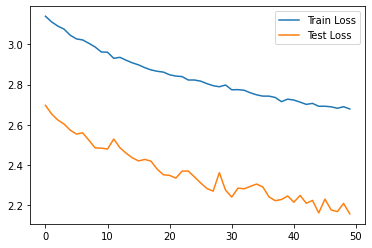

In [47]:
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.legend();

In [48]:
model.eval()

n_correct = 0
n_total = 0
for input, target in train_loader:
  input, target = input.to(device), target.to(device)
  output = model(input)
  _, predictions = torch.max(output, 1)
  n_correct += (predictions == target).sum().item()
  n_total += target.shape[0]

train_acc = n_correct/n_total

n_correct = 0
n_total = 0
for input, target in test_loader:
  input, target = input.to(device), target.to(device)
  output = model(input)
  _, predictions = torch.max(output, 1)
  n_correct += (predictions == target).sum().item()
  n_total += target.shape[0]

test_acc = n_correct/n_total
print(f'Train Accuracy: {train_acc},  Test Accuracy: {test_acc}')

Train Accuracy: 0.34312,  Test Accuracy: 0.43186
